# Tests

Purpose:
- Explore for simple correlatd and uncorrelated scenarios under what circumstances the correct posteriors can be reproduced
- Demonstrate how this can be done with **minimum effort** and **small feedback loop**

In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
%load_ext autoreload
%autoreload 2
swyft.set_verbosity(5)

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test


In [2]:
DEVICE = 'cuda:0'

In [3]:
zdim = 10
param_names = ["z"+str(i) for i in range(zdim)]

### Test 1 - Small signal, huge noise, large data

In [31]:
T = np.random.randn(10000, zdim)
sigma = 10.
F = T.T.dot(T)/sigma**2
errors0 = np.diag(np.linalg.inv(F))**0.5
errors0

array([0.10005663, 0.09939594, 0.09996579, 0.09929025, 0.0994335 ,
       0.09940619, 0.09962006, 0.10007285, 0.09920407, 0.09873448])

In [25]:
def model(params, sigma = sigma):
    z = np.array([params[key] for key in param_names])
    x = T.dot(z)
    return dict(x=x)

In [26]:
def noise(obs, params, sigma = sigma):
    x = obs['x']
    x = x + np.random.randn(*x.shape) * sigma
    return dict(x=x)

In [27]:
par0 = {k: 0.5 for k in param_names}
obs0 = model(par0)
obs0

{'x': array([ 0.28893481, -2.24279952,  1.11722825, ...,  1.52272004,
        -1.66513   ,  0.56292481])}

In [28]:
prior = swyft.Prior({k: ["uniform", 0., 1.] for k in param_names})

In [29]:
s = swyft.NestedRatios(model, prior, noise = noise, obs = obs0, device = DEVICE, Ninit = 3000)

In [30]:
s.run(max_rounds=1, train_args = dict(lr_schedule = [1e-3, 1e-4]))

DEBUG:root:Creating new empty MemoryCache.
DEBUG:root:Creating Cache.
DEBUG:root:  params = ['z0', 'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9']
DEBUG:root:  obs_shapes = {'x': (10000,)}
INFO:root:NRE round: R = 1
INFO:root:Number of training samples is N_R = 3000
INFO:root:Additional simulations are required after growing the cache.
Simulate:   1%|          | 18/2935 [00:00<00:16, 178.19it/s]

Creating new cache.
  adding 2935 new samples to simulator cache.


Simulate: 100%|██████████| 2935/2935 [00:16<00:00, 176.01it/s]
INFO:root:Starting neural network training.
DEBUG:root:Initializing swyft.Module with tag `DefaultHead`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'x': torch.Size([10000])}, 'obs_transform': None, 'online_norm': True}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(10000, [('z0',), ('z1',), ('z2',), ('z3',), ('z4',), ('z5',), ('z6',), ('z7',), ('z8',), ('z9',)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:  combinations = None
DEBUG:root:  batch_size = 32
DEBUG:root:  nworkers = 0
DEBUG:root:  max_epochs = 10
DEBUG:root:  early_stopping_patience = 1
DEBUG:root:  lr_schedule = [0.001, 0.0001]
DEBUG:root:  percent_validation = 0
DEBUG:root:lr: 0.001
DEBUG:root:validation loss = 13.84
DEBUG:root:validation loss = 13

In [32]:
samples = s.marginals(obs0, 100000)
for i in range(zdim):
    samples['params']['z%i'%i] = (samples['params']['z%i'%i] - par0['z%i'%i])/errors0[i]

In [33]:
errors0

array([0.10005663, 0.09939594, 0.09996579, 0.09929025, 0.0994335 ,
       0.09940619, 0.09962006, 0.10007285, 0.09920407, 0.09873448])

In [34]:
len(s.cache)

2935

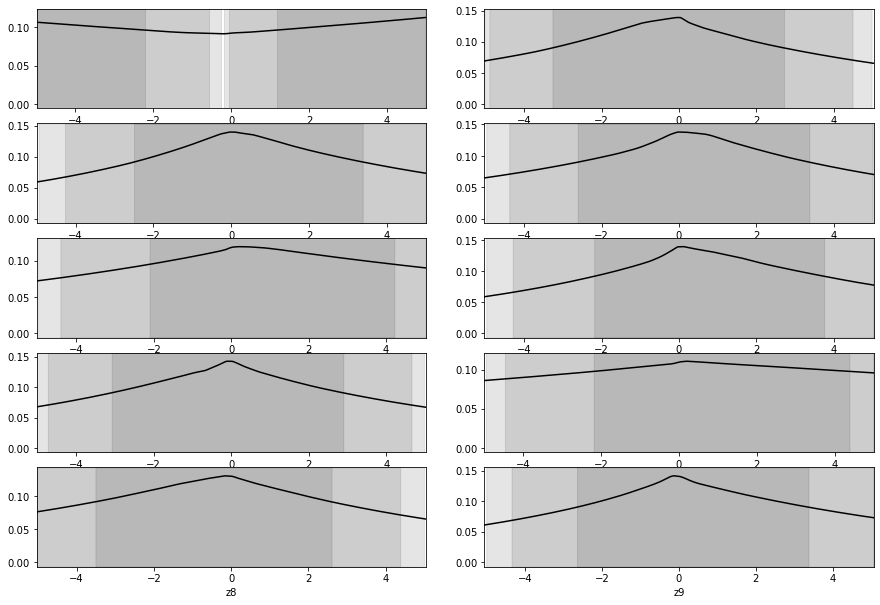

In [36]:
swyft.plot1d(samples, param_names, ncol = 2, grid_interpolate = True)

#### Conclusions
- That's complete shit

### Test 2 - Small signal, huge noise, large data, more training data

In [42]:
T = np.random.randn(10000, zdim)
sigma = 10.
F = T.T.dot(T)/sigma**2
errors0 = np.diag(np.linalg.inv(F))**0.5
errors0

array([0.10119984, 0.0994762 , 0.09845069, 0.10105108, 0.100751  ,
       0.0988316 , 0.09982355, 0.10037867, 0.10025632, 0.10041235])

In [43]:
def model(params, sigma = sigma):
    z = np.array([params[key] for key in param_names])
    x = T.dot(z)
    return dict(x=x)

In [44]:
def noise(obs, params, sigma = sigma):
    x = obs['x']
    x = x + np.random.randn(*x.shape) * sigma
    return dict(x=x)

In [45]:
par0 = {k: 0.5 for k in param_names}
obs0 = model(par0)
obs0

{'x': array([-0.37794912,  0.13078895,  0.37002754, ...,  1.69910435,
         3.05826659,  1.71159837])}

In [46]:
prior = swyft.Prior({k: ["uniform", 0., 1.] for k in param_names})

In [47]:
s = swyft.NestedRatios(model, prior, noise = noise, obs = obs0, device = DEVICE, Ninit = 30000)

In [48]:
s.run(max_rounds=1, train_args = dict(lr_schedule = [1e-3, 1e-4]))

DEBUG:root:Creating new empty MemoryCache.
DEBUG:root:Creating Cache.
DEBUG:root:  params = ['z0', 'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9']
DEBUG:root:  obs_shapes = {'x': (10000,)}
INFO:root:NRE round: R = 1
INFO:root:Number of training samples is N_R = 30000


Creating new cache.


INFO:root:Additional simulations are required after growing the cache.
Simulate:   0%|          | 21/30207 [00:00<02:29, 202.31it/s]

  adding 30207 new samples to simulator cache.


Simulate: 100%|██████████| 30207/30207 [02:28<00:00, 202.99it/s]
INFO:root:Starting neural network training.
DEBUG:root:Initializing swyft.Module with tag `DefaultHead`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'x': torch.Size([10000])}, 'obs_transform': None, 'online_norm': True}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(10000, [('z0',), ('z1',), ('z2',), ('z3',), ('z4',), ('z5',), ('z6',), ('z7',), ('z8',), ('z9',)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:  combinations = None
DEBUG:root:  batch_size = 32
DEBUG:root:  nworkers = 0
DEBUG:root:  max_epochs = 10
DEBUG:root:  early_stopping_patience = 1
DEBUG:root:  lr_schedule = [0.001, 0.0001]
DEBUG:root:  percent_validation = 0
DEBUG:root:lr: 0.001
DEBUG:root:validation loss = 13.32
DEBUG:root:validation loss = 

In [49]:
samples = s.marginals(obs0, 100000)
for i in range(zdim):
    samples['params']['z%i'%i] = (samples['params']['z%i'%i] - par0['z%i'%i])/errors0[i]

In [50]:
errors0

array([0.10119984, 0.0994762 , 0.09845069, 0.10105108, 0.100751  ,
       0.0988316 , 0.09982355, 0.10037867, 0.10025632, 0.10041235])

In [51]:
len(s.cache)

30207

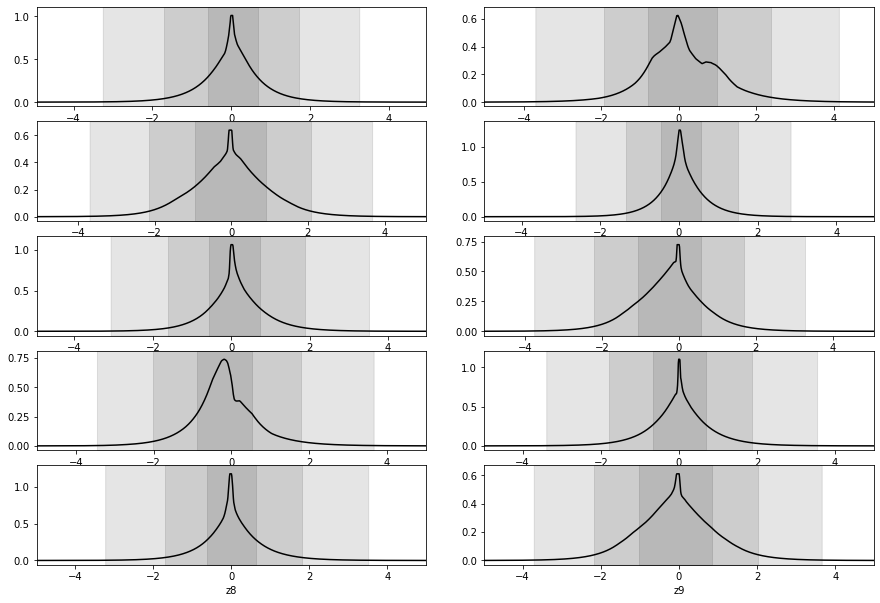

In [52]:
swyft.plot1d(samples, param_names, ncol = 2, grid_interpolate = True)

#### Conclusions
- Posteriors look funny, but +- 2 and +- 3 sigma tails are roughly correct.

### Test 3 - Small signal, huge noise, large data, more training data

In [53]:
T = np.random.randn(10000, zdim)
sigma = 10.
F = T.T.dot(T)/sigma**2
errors0 = np.diag(np.linalg.inv(F))**0.5
errors0

array([0.09932795, 0.10030609, 0.10049986, 0.09996883, 0.1011427 ,
       0.09999632, 0.1002276 , 0.09979546, 0.10058963, 0.10023375])

In [54]:
def model(params, sigma = sigma):
    z = np.array([params[key] for key in param_names])
    x = T.dot(z)
    return dict(x=x)

In [55]:
def noise(obs, params, sigma = sigma):
    x = obs['x']
    x = x + np.random.randn(*x.shape) * sigma
    return dict(x=x)

In [56]:
par0 = {k: 0.5 for k in param_names}
obs0 = model(par0)
obs0

{'x': array([-0.00703159, -1.91253831,  1.85292995, ...,  0.12801862,
        -2.7262103 ,  0.00467289])}

In [57]:
prior = swyft.Prior({k: ["uniform", 0., 1.] for k in param_names})

In [64]:
class Head(swyft.Module):
    def __init__(self, obs_shapes):
        super().__init__(obs_shapes=obs_shapes)
        self.n_features = 10
        self.onl_f = swyft.OnlineNormalizationLayer(torch.Size([10000]))
        self.l1 = torch.nn.Linear(10000, 10)
        
    def forward(self, obs):
        x=obs['x']
        x = self.onl_f(x)
        x = self.l1(x)
        return x

DEBUG:root:Registering new swyft.Module with tag `Head`


In [67]:
s = swyft.NestedRatios(model, prior, noise = noise, obs = obs0, device = DEVICE, Ninit = 3000)

In [68]:
s.run(max_rounds=1, train_args = dict(lr_schedule = [1e-3, 1e-4]), head = Head)

DEBUG:root:Creating new empty MemoryCache.
DEBUG:root:Creating Cache.
DEBUG:root:  params = ['z0', 'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9']
DEBUG:root:  obs_shapes = {'x': (10000,)}
INFO:root:NRE round: R = 1
INFO:root:Number of training samples is N_R = 3000
INFO:root:Additional simulations are required after growing the cache.
Simulate:   1%|          | 19/3001 [00:00<00:16, 183.55it/s]

Creating new cache.
  adding 3001 new samples to simulator cache.


Simulate: 100%|██████████| 3001/3001 [00:16<00:00, 180.38it/s]
INFO:root:Starting neural network training.
DEBUG:root:Initializing swyft.Module with tag `Head`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'x': torch.Size([10000])}}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(10, [('z0',), ('z1',), ('z2',), ('z3',), ('z4',), ('z5',), ('z6',), ('z7',), ('z8',), ('z9',)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:  combinations = None
DEBUG:root:  batch_size = 32
DEBUG:root:  nworkers = 0
DEBUG:root:  max_epochs = 10
DEBUG:root:  early_stopping_patience = 1
DEBUG:root:  lr_schedule = [0.001, 0.0001]
DEBUG:root:  percent_validation = 0
DEBUG:root:lr: 0.001
DEBUG:root:validation loss = 12.23
DEBUG:root:validation loss = 11.5
DEBUG:root:validation loss = 10.93
DEBUG:root:valid

In [69]:
samples = s.marginals(obs0, 100000)
for i in range(zdim):
    samples['params']['z%i'%i] = (samples['params']['z%i'%i] - par0['z%i'%i])/errors0[i]

In [70]:
errors0

array([0.09932795, 0.10030609, 0.10049986, 0.09996883, 0.1011427 ,
       0.09999632, 0.1002276 , 0.09979546, 0.10058963, 0.10023375])

In [71]:
len(s.cache)

3001

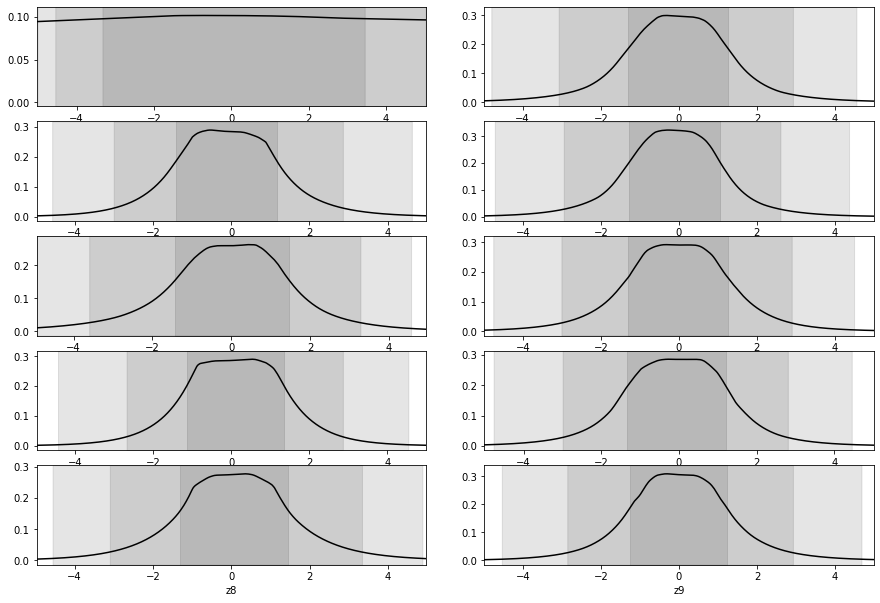

In [72]:
swyft.plot1d(samples, param_names, ncol = 2, grid_interpolate = True)

#### Conclusions
- Not bad for 3000 samples.

### Test 4 - Small signal, huge noise, large data, more training data

In [73]:
T = np.random.randn(10000, zdim)
sigma = 10.
F = T.T.dot(T)/sigma**2
errors0 = np.diag(np.linalg.inv(F))**0.5
errors0

array([0.10052773, 0.09983643, 0.10034019, 0.1007007 , 0.09883068,
       0.10035679, 0.09814388, 0.10029048, 0.10064761, 0.10051404])

In [74]:
def model(params, sigma = sigma):
    z = np.array([params[key] for key in param_names])
    x = T.dot(z)
    return dict(x=x)

In [75]:
def noise(obs, params, sigma = sigma):
    x = obs['x']
    x = x + np.random.randn(*x.shape) * sigma
    return dict(x=x)

In [76]:
par0 = {k: 0.5 for k in param_names}
obs0 = model(par0)
obs0

{'x': array([-3.29551103,  0.31877991,  0.01270899, ...,  1.45043097,
        -1.05004171,  1.39389273])}

In [77]:
prior = swyft.Prior({k: ["uniform", 0., 1.] for k in param_names})

In [78]:
class Head(swyft.Module):
    def __init__(self, obs_shapes):
        super().__init__(obs_shapes=obs_shapes)
        self.n_features = 10
        self.onl_f = swyft.OnlineNormalizationLayer(torch.Size([10000]))
        self.l1 = torch.nn.Linear(10000, 10)
        
    def forward(self, obs):
        x=obs['x']
        x = self.onl_f(x)
        x = self.l1(x)
        return x

DEBUG:root:Registering new swyft.Module with tag `Head`


In [79]:
s = swyft.NestedRatios(model, prior, noise = noise, obs = obs0, device = DEVICE, Ninit = 10000)

In [80]:
s.run(max_rounds=1, train_args = dict(lr_schedule = [1e-3, 1e-4]), head = Head)

DEBUG:root:Creating new empty MemoryCache.
DEBUG:root:Creating Cache.
DEBUG:root:  params = ['z0', 'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'z7', 'z8', 'z9']
DEBUG:root:  obs_shapes = {'x': (10000,)}
INFO:root:NRE round: R = 1
INFO:root:Number of training samples is N_R = 10000
INFO:root:Additional simulations are required after growing the cache.
Simulate:   0%|          | 0/10061 [00:00<?, ?it/s]

Creating new cache.
  adding 10061 new samples to simulator cache.


Simulate: 100%|██████████| 10061/10061 [00:50<00:00, 200.22it/s]
INFO:root:Starting neural network training.
DEBUG:root:Initializing swyft.Module with tag `Head`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'x': torch.Size([10000])}}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(10, [('z0',), ('z1',), ('z2',), ('z3',), ('z4',), ('z5',), ('z6',), ('z7',), ('z8',), ('z9',)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:  combinations = None
DEBUG:root:  batch_size = 32
DEBUG:root:  nworkers = 0
DEBUG:root:  max_epochs = 10
DEBUG:root:  early_stopping_patience = 1
DEBUG:root:  lr_schedule = [0.001, 0.0001]
DEBUG:root:  percent_validation = 0
DEBUG:root:lr: 0.001
DEBUG:root:validation loss = 10.61
DEBUG:root:validation loss = 9.973
DEBUG:root:validation loss = 9.733
DEBUG:root:va

In [81]:
samples = s.marginals(obs0, 100000)
for i in range(zdim):
    samples['params']['z%i'%i] = (samples['params']['z%i'%i] - par0['z%i'%i])/errors0[i]

In [82]:
errors0

array([0.10052773, 0.09983643, 0.10034019, 0.1007007 , 0.09883068,
       0.10035679, 0.09814388, 0.10029048, 0.10064761, 0.10051404])

In [83]:
len(s.cache)

10061

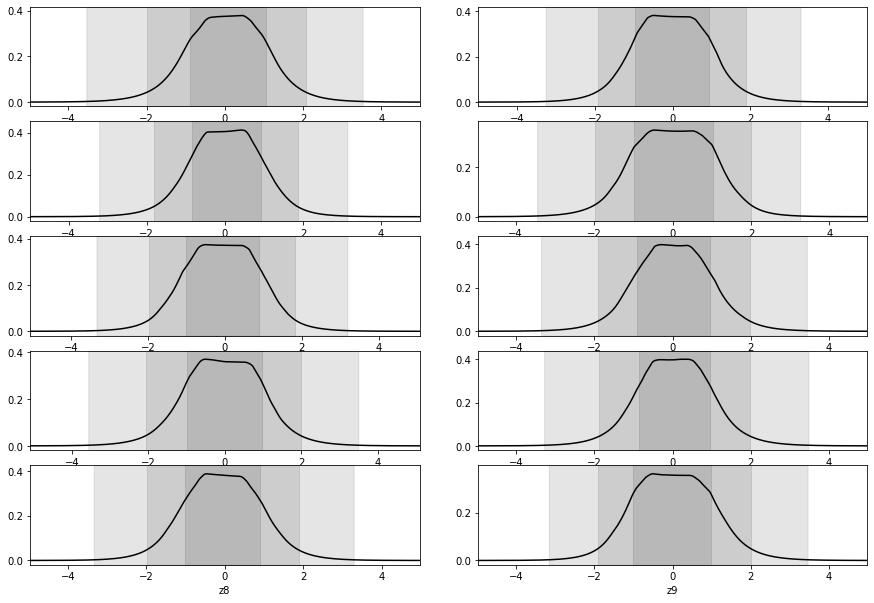

In [84]:
swyft.plot1d(samples, param_names, ncol = 2, grid_interpolate = True)

#### Conclusions
- Random signal in 10000 bins analysed with 10000 samples, with linear pre-processing.  Looks good!  Much smoother performance than with pure MLP.